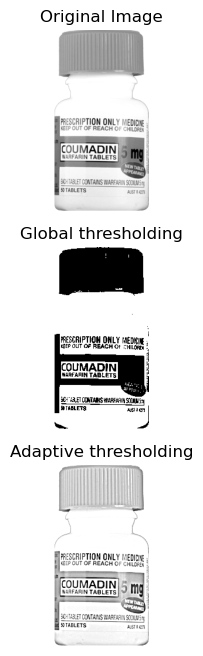

Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


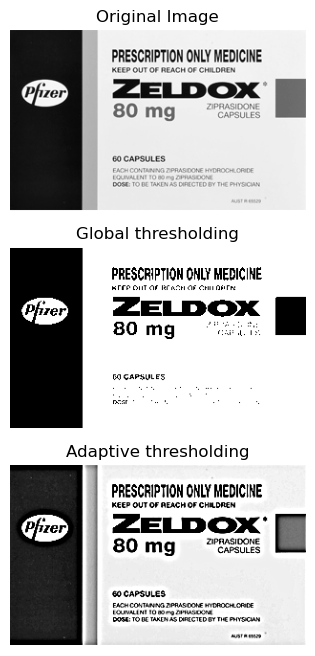

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


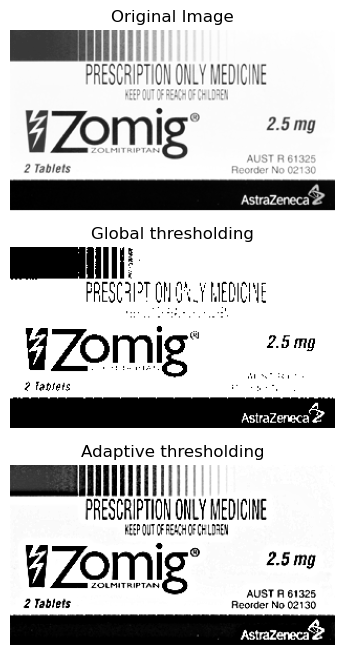

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


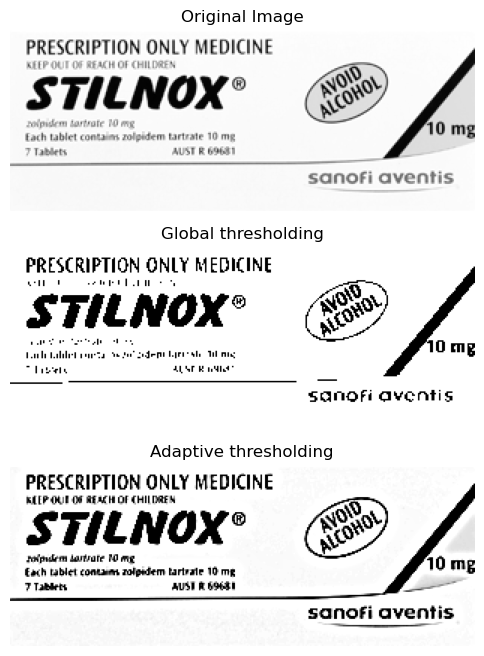

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


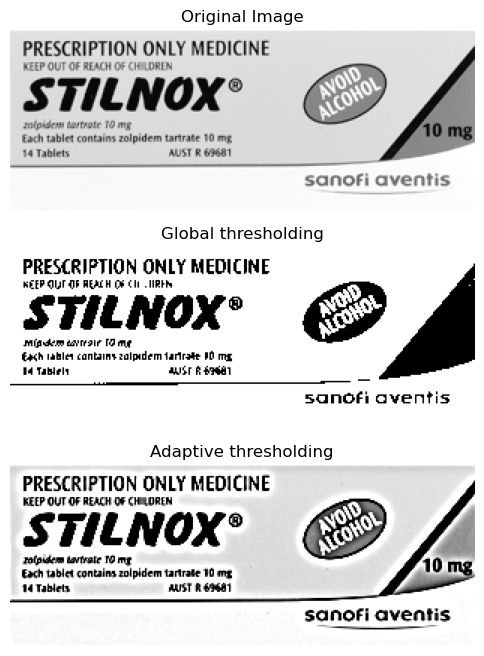

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


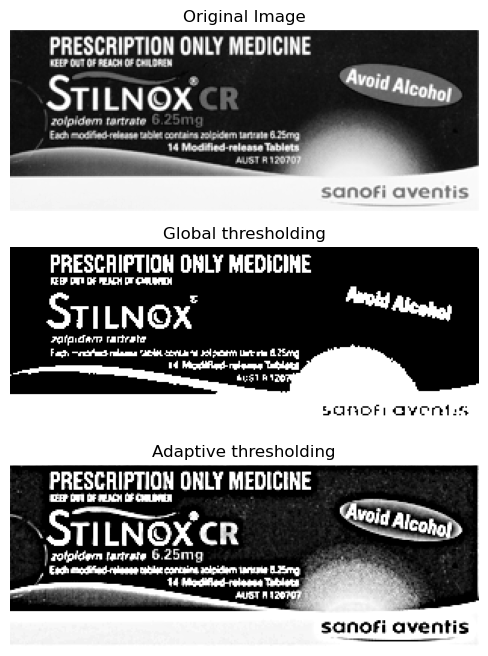

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


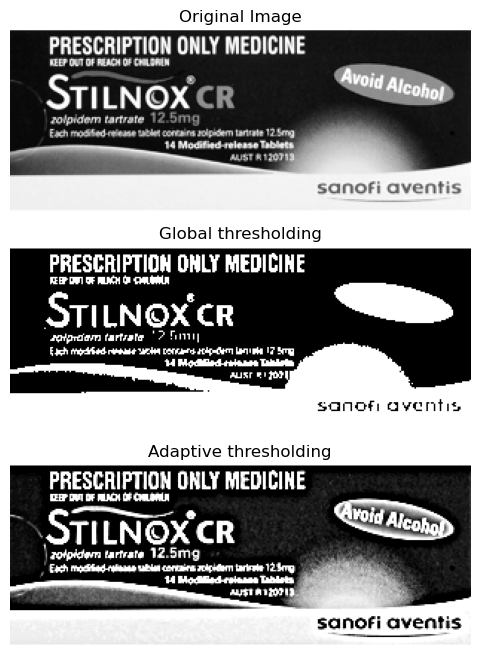

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


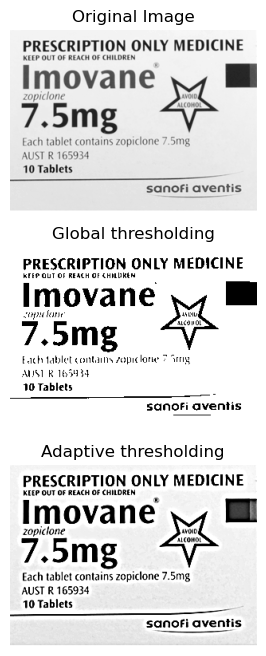

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


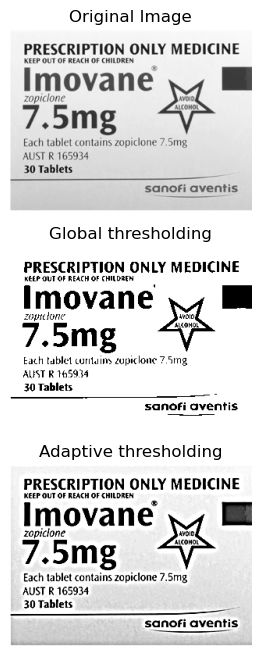

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


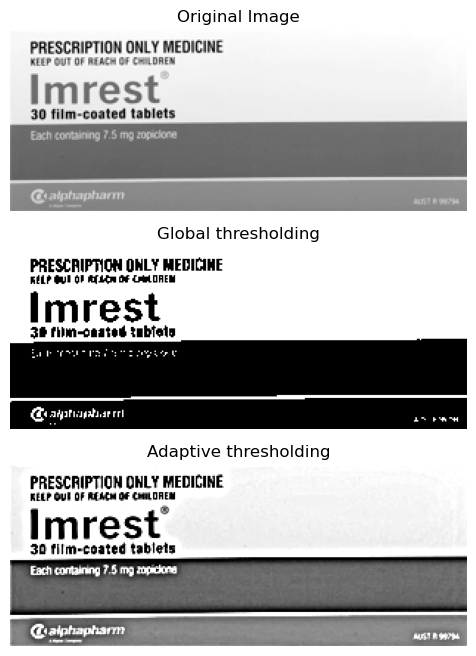

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [13]:
import os
from skimage import io, filters, transform, img_as_ubyte, img_as_float, color
from skimage.filters import unsharp_mask, threshold_local, threshold_otsu
import matplotlib.pyplot as plt
from skimage import data
import cv2

def threshold_images(input_folder, output_folder):
    """ 
    notes: resizing messed up the image pretty badly so i commented it out, 
    this and ignore the lossy compression wearnings, converting the image 
    also destroys most clarity and the results will be very different from what is shown here
    """

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'): 
            # Read the image
            img_path = os.path.join(input_folder, filename)
            image = io.imread(img_path, as_gray=True)
            original = io.imread(img_path, as_gray=True)

            # # Resize the image
            # # Calculate the scaling factor to fit within the specified range
            # scale_factor = min(max_width / image.shape[1], max_height / image.shape[0])
            # image = transform.resize(image, (int(image.shape[0] * scale_factor), int(image.shape[1] * scale_factor)))

            # Apply adaptive thresholding, doing two types here and comparing the performance
            global_thresh = threshold_otsu(image)
            binary_global = image > global_thresh

            block_size = 3
            offset = 0.0000001
            thresh_meth = 'gaussian'
            image = threshold_local(image, block_size, thresh_meth, offset)


            # Apply unsharp masking filter for sharpening
            # Parameters:
            # - radius: The radius of the Gaussian blur used for the unsharp masking (larger values mean stronger blur)
            # - amount: The strength of the sharpening (higher values mean stronger sharpening)
            image = filters.unsharp_mask(image, radius=3, amount=3.5)
            binary_global = filters.unsharp_mask(binary_global, radius=3, amount=3.5)

            # Display the variations
            fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
            ax0, ax1, ax2 = axes
            plt.gray()

            ax0.imshow(original)
            ax0.set_title('Original Image')

            ax1.imshow(binary_global)
            ax1.set_title('Global thresholding')

            ax2.imshow(image)
            ax2.set_title('Adaptive thresholding')

            for ax in axes:
                ax.axis('off')

            plt.show()
            img = img_as_ubyte(binary_global)
            cv2.imshow("image", img)


            # Save thresholded image to output folder
            output_path = os.path.join(output_folder, filename)
            io.imsave(output_path, image) 

input_folder = 'D:/2024/FYP/DATASETS/mydispense_meds/mydispense_meds/testing images'
output_folder = 'D:/2024/FYP/DATASETS/mydispense_meds/processed_images/'

# Apply try_all_threshold to PNG images in the input folder
threshold_images(input_folder, output_folder)

### References:

https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding_guide.html

https://stackoverflow.com/questions/33091755/bradley-roth-adaptive-thresholding-algorithm-how-do-i-get-better-performance

https://stackoverflow.com/questions/72555528/how-to-binarize-an-image-when-image-has-white-text-on-black-background-and-vice

#the link above gave me an anuerysm




In [ ]:
%pip install tensorflow

In [ ]:
""" i really hate this """
import tensorflow as tf 
from tensorflow.keras import layers, models

# define input shape, required?

def backbone(input_shape):
    # we use a bunch of CNN, which may need to be refined later
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Additional layers can be added as needed
    return models.Model(input_img, x)

def feature_giant(bbmodel):
    input_features = bbmodel.output
    # upsample
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(input_features)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    return models.Model(bbmodel.input, x)

# prediction maps
def prediction_maps(feature_giant_model):
    input_img = feature_giant_model.input
    features = feature_giant_model.output

    # Predicted probability map (binary classification)
    prob_map = layers.Conv2D(1, (1, 1), activation='sigmoid', name='prob_map')(features)
    
    # Predicted threshold map
    threshold_map = layers.Conv2D(1, (1, 1), activation='sigmoid', name='threshold_map')(features)
    
    return models.Model(input_img, [prob_map, threshold_map])

def approx_binarization(prob, threshold):
    binarized_map = tf.keras.backend.greater_equal(prob_map, threshold_map)
    return binarized_map

def binmodel(shape):
    # Create the backbone and feature giant models
    backbone_model = backbone(input_shape)
    feature_giant_model = feature_giant(backbone_model)
    
    # Create the prediction maps model
    prediction_maps_model = prediction_maps(feature_giant_model)
    
    # Define the input and outputs
    input_img = prediction_maps_model.input
    prob_map, threshold_map = prediction_maps_model.output
    
    # Calculate the binarized map
    binarized_map = approx_binarization(prob_map, threshold_map)
    
    # Create the final model
    return models.Model(input_img, [prob_map, threshold_map, binarized_map])

input_shape = (128, 128, 3)  # Adjust input shape as needed
model = binmodel(input_shape)

# Compile the model
model.compile(optimizer='adam', loss={'prob_map': 'binary_crossentropy',
                                      'threshold_map': 'mse',
                                      'binarized_map': 'binary_crossentropy'})



In [ ]:
def bounding():
    ''' dbnet algorithm used, with this hopefully we can by pass the binarization problem '''
    pass

def meat():
    pass